In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [14]:
df = pd.read_csv('pokindex_data.csv')
df

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,WinningPercentage
0,70,90,45,15,45,50,36.290323
1,40,27,60,37,50,66,36.220472
2,75,75,60,83,60,60,39.344262
3,85,115,80,105,80,50,30.630631
4,83,106,65,86,65,85,66.406250
...,...,...,...,...,...,...,...
195,50,65,64,44,48,43,21.969697
196,60,85,69,65,79,80,57.600000
197,45,50,43,40,38,62,40.441176
198,55,45,50,45,65,80,55.462185


In [13]:
y = df['WinningPercentage']

scaler = StandardScaler()
X = scaler.fit_transform(df.drop('WinningPercentage', axis=1))

df_new = pd.DataFrame(X, columns=df.columns[:-1])
df_new['WinningPercentage'] = y

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,WinningPercentage
0,0.152909,0.405283,-0.922707,-1.788067,-1.045263,-0.649041,36.290323
1,-1.180600,-1.596508,-0.433985,-1.110710,-0.852552,-0.094897,36.220472
2,0.375161,-0.071334,-0.433985,0.305580,-0.467131,-0.302701,39.344262
3,0.819664,1.199645,0.217644,0.982936,0.303712,-0.649041,30.630631
4,0.730763,0.913675,-0.271078,0.397947,-0.274420,0.563148,66.406250
...,...,...,...,...,...,...,...
195,-0.736097,-0.389078,-0.303659,-0.895188,-0.929636,-0.891478,21.969697
196,-0.291594,0.246411,-0.140752,-0.248621,0.265170,0.389979,57.600000
197,-0.958349,-0.865695,-0.987870,-1.018344,-1.315058,-0.233433,40.441176
198,-0.513846,-1.024568,-0.759800,-0.864399,-0.274420,0.389979,55.462185


<Axes: xlabel='PC1', ylabel='PC2'>

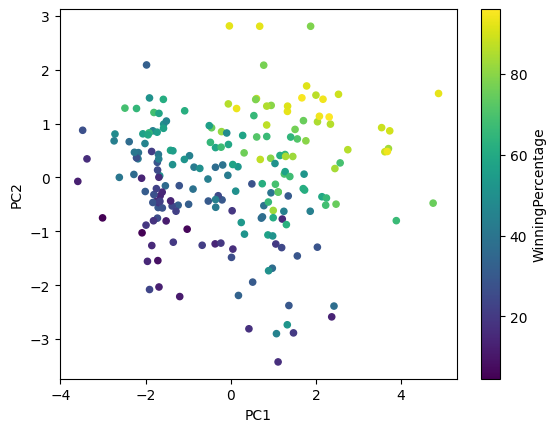

In [19]:
# please visualize the data in 2D using PCA

import matplotlib.pyplot as plt

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

df_pca['WinningPercentage'] = y

df_pca.plot.scatter(x='PC1', y='PC2', c='WinningPercentage', colormap='viridis')